In [1]:
!nvidia-smi

Tue Jul 25 11:20:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   30C    P0    34W / 250W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from pathlib import Path
from functools import partial

import torch

from gnn_tracking.training.ml import MLModule
from gnn_tracking.training.callbacks import PrintValidationMetrics
from gnn_tracking.models.graph_construction import GraphConstructionFCNN
from gnn_tracking.metrics.losses import GraphConstructionHingeEmbeddingLoss
from gnn_tracking.graph_construction.k_scanner import GraphConstructionKNNScanner

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from gnn_tracking.utils.loading import TrackingDataModule
from gnn_tracking.utils.dictionaries import to_floats

from torch_geometric.data import Data
from torch import nn
from pytorch_lightning.core.mixins import HyperparametersMixin

import pandas as pd

In [3]:
val_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9")
assert val_dir.is_dir()

In [4]:
train_dirs = []
train_dir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/")
for i in range(1,9):
    d = os.path.join(train_dir, f"part_{i}")
    if os.path.isdir(d):
        train_dirs.append(d)

In [5]:
train_dirs

['/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_2',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_3',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_4',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_5',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_6',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_7',
 '/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_8']

In [6]:
dm = TrackingDataModule(
    train=dict(
        dirs=train_dirs,
        batch_size=1,
        stop=50
    ),
    val=dict(
        dirs=[val_dir],
        stop=10,
    ),
    # could also configure a 'test' set here
)

In [7]:
# This is called by the Trainer automatically and sets up the datasets
dm.setup(stage="fit")  # 'fit' combines 'train' and 'val'
# Now the datasets are available:
dm.datasets

[11:21:26] INFO: DataLoader will load 50 graphs (out of 7743 available).
[11:21:26] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21049_s0.pt
[11:21:26] INFO: DataLoader will load 10 graphs (out of 1000 available).
[11:21:26] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29009_s0.pt


{'train': TrackingDataset(50), 'val': TrackingDataset(10)}

In [8]:
class CollectLossHistory(Callback):
    def __init__(self):
        self.data_list = []

    def on_validation_epoch_end(self, trainer, *args):
        if not trainer.sanity_checking:
            self.data_list.append(to_floats(trainer.callback_metrics))

    def get_history(self):
        return pd.DataFrame.from_records(self.data_list)

In [9]:
from torch.optim.lr_scheduler import StepLR

In [10]:
import matplotlib.pyplot as plt

In [11]:
import collections
from torch import Tensor
from gnn_tracking.utils.dictionaries import add_key_suffix

In [12]:
from gnn_tracking.utils.nomenclature import random_trial_name
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import TensorBoardLogger

from wandb_osh.lightning_hooks import TriggerWandbSyncLightningCallback

In [13]:
# name = random_trial_name()

In [14]:
# wandb_logger = WandbLogger(
#     project="mdmm",
#     group="graph-construction",
#     offline=True,
#     version=name,
# )

In [15]:
# tb_logger = TensorBoardLogger(".", version=name)

In [19]:
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, monitor, min_delta=0.0, patience=0, verbose=False,
                 mode='auto', strict=True, check_finite=True, ignore_nan=True):
        super(CustomEarlyStopping, self).__init__(monitor, min_delta, patience,
                                                  verbose, mode, strict)
        self.ignore_nan = ignore_nan

    def on_validation_end(self, trainer, pl_module):
        """
        This method is called at the end of the validation epoch.
        """
        current = trainer.callback_metrics.get(self.monitor)
        if current is None:
            return

        if self.ignore_nan and torch.isnan(current):
            return

        super(CustomEarlyStopping, self).on_validation_end(trainer, pl_module)

In [24]:
def train_model(weight_repulsive, dm, max_epochs=50):
    model = GraphConstructionFCNN(in_dim=14, out_dim=8, depth=4, hidden_dim=128)

    lmodel = MLModule(
        model=model,
        loss_fct=GraphConstructionHingeEmbeddingLoss(p_attr=2, p_rep=2),
        lw_repulsive=weight_repulsive,
        gc_scanner = GraphConstructionKNNScanner(),
        optimizer=partial(torch.optim.Adam, lr=0.001),
    )
    
    early_stopping_callback = EarlyStopping(
        monitor='n_edges_frac_segment50_95',
        patience=5,
        mode='min',
        check_finite=False
    )
    loss_history_cb = CollectLossHistory()

    trainer = Trainer(max_epochs=max_epochs, accelerator="gpu",
                      log_every_n_steps=1, callbacks=[early_stopping_callback,
#                                                       TriggerWandbSyncLightningCallback(),
                                                      PrintValidationMetrics(),
                                                      loss_history_cb,
                                                      TQDMProgressBar(refresh_rate=5)],
                     )
#                       logger=[wandb_logger,tb_logger,])
    
    trainer.fit(model=lmodel, datamodule=dm)

    loss_history = loss_history_cb.get_history()
    return loss_history

In [25]:
loss_history = train_model(weight_repulsive=0.001953029788887701, dm=dm, max_epochs=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[11:43:56] INFO: DataLoader will load 50 graphs (out of 7743 available).
[11:43:56] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21049_s0.pt
[11:43:56] INFO: DataLoader will load 10 graphs (out of 1000 available).
[11:43:56] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/

Sanity Checking: 0it [00:00, ?it/s]

/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/scratch/gpfs/dc3896/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

                   Validation epoch=0                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric                        ┃         Value ┃ Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━┩
│ attractive                    │       0.11741 │   nan │
│ attractive_train              │       0.09994 │   nan │
│ attractive_weighted           │       0.11741 │   nan │
│ attractive_weighted_train     │       0.09994 │   nan │
│ frac100_at_frac_segment50_80  │           nan │   nan │
│ frac100_at_frac_segment50_85  │           nan │   nan │
│ frac100_at_frac_segment50_88  │           nan │   nan │
│ frac100_at_frac_segment50_90  │           nan │   nan │
│ frac100_at_frac_segment50_93  │           nan │   nan │
│ frac100_at_frac_segment50_95  │           nan │   nan │
│ frac100_at_frac_segment50_97  │           nan │   nan │
│ frac100_at_frac_segment50_99  │           nan │   nan │
│ frac100_at_max_frac_segment50 │       0.08489 │   nan │
│ frac75_at_fr

Validation: 0it [00:00, ?it/s]

                    Validation epoch=1                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                        ┃         Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                    │       0.17805 │ 0.01301 │
│ attractive_train              │       0.19054 │     nan │
│ attractive_weighted           │       0.17805 │ 0.01301 │
│ attractive_weighted_train     │       0.19054 │     nan │
│ frac100_at_frac_segment50_80  │           nan │     nan │
│ frac100_at_frac_segment50_85  │           nan │     nan │
│ frac100_at_frac_segment50_88  │           nan │     nan │
│ frac100_at_frac_segment50_90  │           nan │     nan │
│ frac100_at_frac_segment50_93  │           nan │     nan │
│ frac100_at_frac_segment50_95  │           nan │     nan │
│ frac100_at_frac_segment50_97  │           nan │     nan │
│ frac100_at_frac_segment50_99  │           nan │     nan │
│ frac100_at_max_frac_segment50 │       

Validation: 0it [00:00, ?it/s]

                    Validation epoch=2                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                        ┃         Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                    │       0.20071 │ 0.00670 │
│ attractive_train              │       0.18244 │     nan │
│ attractive_weighted           │       0.20071 │ 0.00670 │
│ attractive_weighted_train     │       0.18244 │     nan │
│ frac100_at_frac_segment50_80  │           nan │     nan │
│ frac100_at_frac_segment50_85  │           nan │     nan │
│ frac100_at_frac_segment50_88  │           nan │     nan │
│ frac100_at_frac_segment50_90  │           nan │     nan │
│ frac100_at_frac_segment50_93  │           nan │     nan │
│ frac100_at_frac_segment50_95  │           nan │     nan │
│ frac100_at_frac_segment50_97  │           nan │     nan │
│ frac100_at_frac_segment50_99  │           nan │     nan │
│ frac100_at_max_frac_segment50 │       

Validation: 0it [00:00, ?it/s]

                    Validation epoch=3                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                        ┃         Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                    │       0.23281 │ 0.00813 │
│ attractive_train              │       0.19935 │     nan │
│ attractive_weighted           │       0.23281 │ 0.00813 │
│ attractive_weighted_train     │       0.19935 │     nan │
│ frac100_at_frac_segment50_80  │           nan │     nan │
│ frac100_at_frac_segment50_85  │           nan │     nan │
│ frac100_at_frac_segment50_88  │           nan │     nan │
│ frac100_at_frac_segment50_90  │           nan │     nan │
│ frac100_at_frac_segment50_93  │           nan │     nan │
│ frac100_at_frac_segment50_95  │           nan │     nan │
│ frac100_at_frac_segment50_97  │           nan │     nan │
│ frac100_at_frac_segment50_99  │           nan │     nan │
│ frac100_at_max_frac_segment50 │       

Validation: 0it [00:00, ?it/s]

                    Validation epoch=4                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric                        ┃         Value ┃   Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ attractive                    │       0.26485 │ 0.01165 │
│ attractive_train              │       0.29079 │     nan │
│ attractive_weighted           │       0.26485 │ 0.01165 │
│ attractive_weighted_train     │       0.29079 │     nan │
│ frac100_at_frac_segment50_80  │           nan │     nan │
│ frac100_at_frac_segment50_85  │           nan │     nan │
│ frac100_at_frac_segment50_88  │           nan │     nan │
│ frac100_at_frac_segment50_90  │           nan │     nan │
│ frac100_at_frac_segment50_93  │           nan │     nan │
│ frac100_at_frac_segment50_95  │           nan │     nan │
│ frac100_at_frac_segment50_97  │           nan │     nan │
│ frac100_at_frac_segment50_99  │           nan │     nan │
│ frac100_at_max_frac_segment50 │       

In [19]:
loss_history

,attractive,repulsive,attractive_weighted,repulsive_weighted,total,attractive_std,repulsive_std,attractive_weighted_std,repulsive_weighted_std,total_std,attractive_train,repulsive_train,attractive_weighted_train,repulsive_weighted_train,total_train
0,0.122595,61.850594,0.122595,0.120796,0.243391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.122420,56.215477,0.122420,0.109790,0.232211,0.000911,0.256984,0.000911,0.000502,0.001070,0.226241,101.054199,0.226241,0.197362,0.423604
2,0.091589,43.909164,0.091589,0.085756,0.177344,0.000563,0.241899,0.000563,0.000472,0.000766,0.124828,55.564877,0.124828,0.108520,0.233348
3,0.082513,40.390972,0.082513,0.078885,0.161397,0.000468,0.191604,0.000468,0.000374,0.000623,0.107307,47.652355,0.107307,0.093066,0.200374
4,0.083337,39.639019,0.083337,0.077416,0.160753,0.000447,0.177248,0.000447,0.000346,0.000590,0.098166,43.425568,0.098166,0.084811,0.182977
5,0.096602,45.268166,0.096602,0.088410,0.185012,0.000440,0.175747,0.000440,0.000343,0.000581,0.092338,40.715446,0.092338,0.079519,0.171857
6,0.082422,41.807194,0.082422,0.081651,0.164072,0.000414,0.197488,0.000414,0.000386,0.000584,0.115160,51.656414,0.115160,0.100886,0.216047
7,0.078418,34.087399,0.078418,0.066574,0.144992,0.000390,0.185093,0.000390,0.000361,0.000545,0.092157,40.934761,0.092157,0.079947,0.172104
8,0.069913,32.238434,0.069913,0.062963,0.132876,0.000442,0.150871,0.000442,0.000295,0.000547,0.082456,36.448990,0.082456,0.071186,0.153643
9,0.069728,29.435843,0.069728,0.057489,0.127217,0.000462,0.144357,0.000462,0.000282,0.000558,0.077776,34.212318,0.077776,0.066818,0.144594


In [20]:
loss_history_2

,attractive_train,repulsive_train,attractive_weighted_train,repulsive_weighted_train,total_train,attractive,repulsive,attractive_weighted,repulsive_weighted,total
0,0.226241,101.054286,0.226241,0.197362,0.423603,0.122595,61.850579,0.122595,0.120796,0.243391
1,0.124828,55.564859,0.124828,0.108520,0.233348,0.122421,56.215456,0.122421,0.109790,0.232211
2,0.107307,47.652343,0.107307,0.093066,0.200374,0.091588,43.909189,0.091588,0.085756,0.177344
3,0.098166,43.425635,0.098166,0.084812,0.182978,0.082513,40.390955,0.082513,0.078885,0.161397
4,0.092338,40.715474,0.092338,0.079519,0.171857,0.083337,39.639024,0.083337,0.077416,0.160753
5,0.115160,51.656410,0.115160,0.100887,0.216047,0.096602,45.268180,0.096602,0.088410,0.185012
6,0.092157,40.934851,0.092157,0.079947,0.172104,0.082422,41.807182,0.082422,0.081651,0.164072
7,0.082456,36.449067,0.082456,0.071186,0.153642,0.078418,34.087414,0.078418,0.066574,0.144992
8,0.077776,34.212293,0.077776,0.066818,0.144594,0.069913,32.238438,0.069913,0.062963,0.132876
9,0.073726,32.197549,0.073726,0.062883,0.136608,0.069728,29.435842,0.069728,0.057489,0.127217


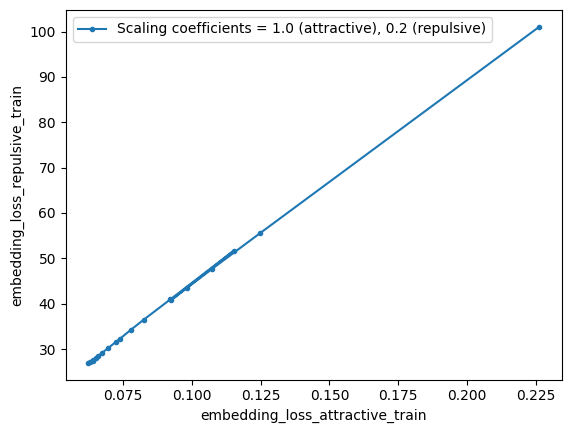

In [21]:
label = f'Scaling coefficients = {1.0} (attractive), {0.2} (repulsive)'
loss_history.plot(x='attractive_train', y='repulsive_train', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive_train')
plt.ylabel('embedding_loss_repulsive_train')

plt.legend()
plt.show()

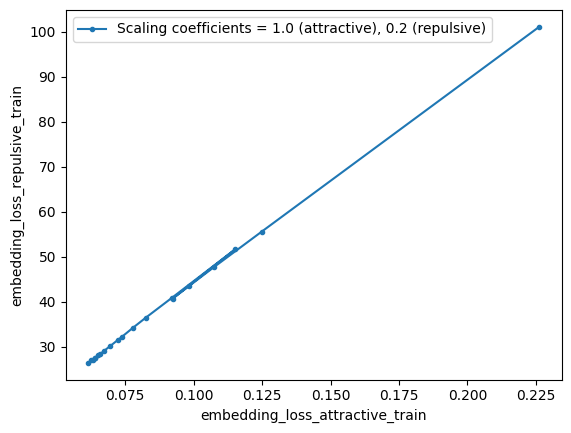

In [22]:
label = f'Scaling coefficients = {1.0} (attractive), {0.2} (repulsive)'
loss_history_2.plot(x='attractive_train', y='repulsive_train', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive_train')
plt.ylabel('embedding_loss_repulsive_train')

plt.legend()
plt.show()

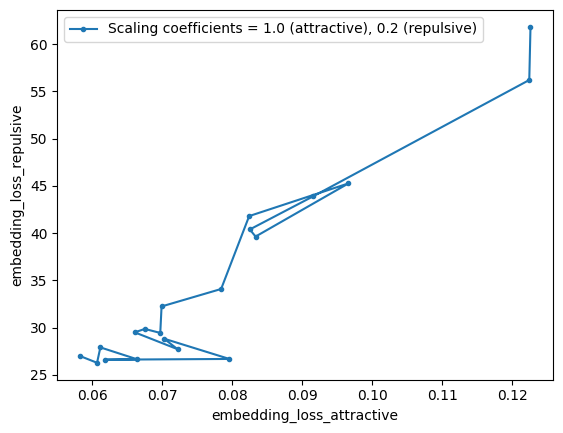

In [23]:
label = f'Scaling coefficients = {1.0} (attractive), {0.2} (repulsive)'
loss_history.plot(x='attractive', y='repulsive', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive')
plt.ylabel('embedding_loss_repulsive')

plt.legend()
plt.show()

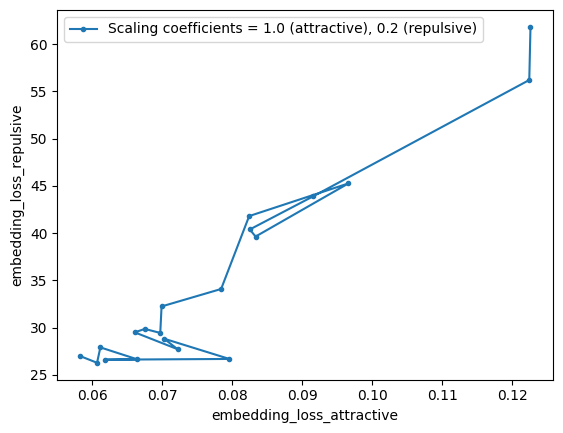

In [24]:
label = f'Scaling coefficients = {1.0} (attractive), {0.2} (repulsive)'
loss_history_2.plot(x='attractive', y='repulsive', marker='o', markersize=3, label=label)

plt.xlabel('embedding_loss_attractive')
plt.ylabel('embedding_loss_repulsive')

plt.legend()
plt.show()

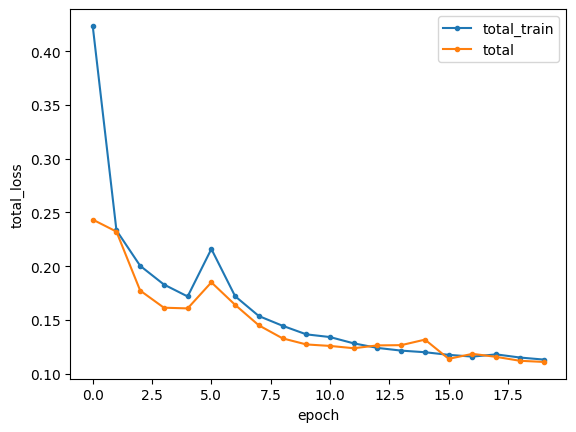

In [25]:
loss_history_2.plot(y=['total_train','total'], use_index=True, marker='o', markersize=3)

plt.xlabel('epoch')
plt.ylabel('total_loss')

plt.legend()
plt.show()

In [26]:
loss_history_2.to_csv('loss_history.csv')